The University of Tokyo  
Special Lectures in Information Science Ⅱ  
Introduction to Near-Term Quantum Computing  
# 8. 古典計算によるシミュレーション

Yoshiaki Kawase (Jun 07, 2024)

元のコードは[こちら](https://github.com/puyokw/2024UTokyo_lecture8/blob/main/20240607_UTokyo_ClassicalSimulation_revised_0909.ipynb)、元のスライドは[こちら](https://github.com/puyokw/2024UTokyo_lecture8/blob/main/20240607_UTokyo_ClassicalSimulation_slide_revised.pdf)をご覧ください。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import qiskit
qiskit.__version__

'1.2.0'

In [2]:
import numpy as np
import math
import random
import time

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

#from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp

## 行列積状態 (Matrics Product State, MPS) シミュレーター
以下の回路を使って、MPS シミュレーターで、それがどのように機能するかを確認します。

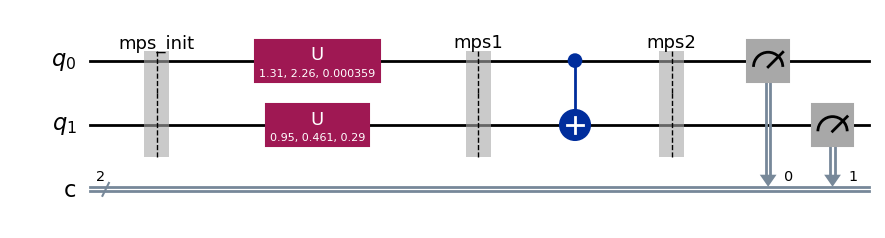

In [3]:
mps_simulator = AerSimulator(method='matrix_product_state')
n_qubits=2
seed = 1
np.random.seed(seed)
random.seed(seed)
angles = np.random.rand(9)*math.pi # ランダムな角度を準備します

qc = QuantumCircuit(n_qubits, n_qubits)
qc.save_matrix_product_state(label='mps_init')

qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state
qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state
qc.save_matrix_product_state(label='mps1')

qc.cx(0,1)
qc.save_matrix_product_state(label='mps2')
qc.measure(range(n_qubits), range(n_qubits))
qc.draw(output="mpl")
plt.show()

まず初期状態、`mps_init` での状態を確認します。

In [5]:
tqc = transpile(qc, mps_simulator)
result = mps_simulator.run(tqc).result()
result.data(0)['mps_init']

([(array([[1.+0.j]]), array([[0.+0.j]])),
  (array([[1.+0.j]]), array([[0.+0.j]]))],
 [array([1.])])

Qiskit Aerのチュートリアル https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html#id1 より、
MPS シミュレーターを使用すると、 量子状態は、正規形式 $\Gamma^{(1)} \lambda^{(1)} \cdots \Gamma^{(n-1)} \lambda^{(n-1)} \Gamma^{(n)}$ で表されます。 
ここで、$\Gamma$ はテンソルを表し、$\lambda$ は正規化係数を表します。
したがって、シミュレーターはテンソルと正規化係数のリストを持ちます。

シミュレーターの出力は、テンソル A と B のリストと正規化係数 $\lambda$ のリストを含みます。
量子状態を $ |\psi_{init}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$ で記述すると、出力は、テンソルのリスト $[A,B]=[A^0,A^1,B^0,B^1]$ と正規化係数 $[\lambda]$ になります。


上の `mps_init` 時点での出力結果から、初期状態 $|00\rangle$ は $A^{0} = 1, A^{1}=0, B^{0}=1, B^{1}=0, \lambda=1$ となる $ |\psi_{init}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$ で記述されていることがわかります。


In [6]:
A0 = 1
A1 = 0
B0 = 1
B1 = 0

次に、上記回路では、q0にユニタリーゲートUを作用させています。ユニタリーゲートは、以下のような $2 \times 2$ 行列

$U=
\begin{pmatrix}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{pmatrix}
=u_{00} |0\rangle \langle 0|+u_{01} |0\rangle \langle 1|+u_{10} |1\rangle \langle 0|+u_{11} |1\rangle \langle 1|$　であるため、この作用は

$(U\otimes I)|\psi_{init} \rangle 
= \sum_{\sigma_0} U A^{\sigma_0} |\sigma_0\rangle \otimes \sum_{\sigma_1} B^{\sigma_1} |\sigma_1 \rangle
= \bigg( ( A^{0}u_{00} + A^{1}u_{01} )|0\rangle + (A^{0}u_{10} + A^{1}u_{11} ) |1\rangle \bigg) \otimes \sum_{\sigma_1} B^{\sigma_1} |\sigma_1 \rangle$

となります。QiskitのUゲートの定義より、


$U(\theta_1,\theta_2,\theta_3)=
\begin{pmatrix}
\cos{(\theta_1/2)} & -e^{i\theta_3}\sin{(\theta_1/2)} \\
e^{i\theta_2}\sin{(\theta_1/2)} & e^{i(\theta_2+\theta_3)} \cos{(\theta_1/2)}
\end{pmatrix}
$

$\theta_1、\theta_2$、$\theta_3$に値を割り当て、Uゲートを量子状態に適用し$A^0$ と $A^1$ を計算します：

In [7]:
# QiskitのUゲートの定義より
u00 = np.cos(angles[0]/2)
u01 = -np.exp(1.0j*angles[2])*np.sin(angles[0]/2)
u10 = np.exp(1.0j*angles[1])*np.sin(angles[0]/2)
u11 = np.exp(1.0j*(angles[1]+angles[2]))*np.cos(angles[0]/2)
print( "new A^0=", A0*u00+A1*u01, "new A^1=", A0*u10+A1*u11)

new A^0= (0.7930134282051604+0j) new A^1= (-0.3887996598361402+0.4690037603235188j)


同様に、q1にユニタリーゲートUを作用させ、$B^0$ と $B^1$ を次のように計算します：

In [8]:
# Uゲートの定義より
v00 = np.cos(angles[3]/2)
v01 = -np.exp(1.0j*angles[5])*np.sin(angles[3]/2)
v10 = np.exp(1.0j*angles[4])*np.sin(angles[3]/2)
v11 = np.exp(1.0j*(angles[4]+angles[5]))*np.cos(angles[3]/2)
print( "new B^0=", B0*v00+B1*u01, "new B^1=", B0*v10+B1*v11)

new B^0= (0.8893371274812134+0j) new B^1= (0.4095090690923406+0.20342516072155026j)


MPSシミュレーターによる `mps1` 時点でのテンソル A と B の値と正規化係数 $\lambda$ を見てみましょう。

In [9]:
result.data(0)['mps1']

([(array([[0.79301343+0.j]]), array([[-0.38879966+0.46900376j]])),
  (array([[0.88933713+0.j]]), array([[0.40950907+0.20342516j]]))],
 [array([1.])])

上記のケースと同様に、シミュレーターの出力には、テンソルAとBのリストと、正規化係数$\lambda$を含むリストが含まれます。
量子状態を $ |\psi_{1}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$ で記述すると、出力はテンソル $[A,B]=[A^0,A^1,B^0,B^1]$ と正規化係数 $[\lambda]$ のリストとなり、テンソルと正規化係数は、以下のように求められます。

In [10]:
print("A^0=", result.data(0)['mps1'][0][0][0][0], ", A^1=", result.data(0)['mps1'][0][0][1][0], 
      "\nB^0=", result.data(0)['mps1'][0][1][0][0], ", B^1=", result.data(0)['mps1'][0][1][1][0], 
      "\nlambda=", result.data(0)['mps1'][1][0])

A^0= [0.79301343+0.j] , A^1= [-0.38879966+0.46900376j] 
B^0= [0.88933713+0.j] , B^1= [0.40950907+0.20342516j] 
lambda= [1.]


`mps1` の状態において、ユニタリーゲートの定義から計算した結果が、MPSシミュレーターの結果と一致していることがわかります。

In [11]:
print( "new A^0=", A0*u00+A1*u01, ", new A^1=", A0*u10+A1*u11)
print( "new B^0=", B0*v00+B1*u01, ", new B^1=", B0*v10+B1*v11)

new A^0= (0.7930134282051604+0j) , new A^1= (-0.3887996598361402+0.4690037603235188j)
new B^0= (0.8893371274812134+0j) , new B^1= (0.4095090690923406+0.20342516072155026j)


次に、シミュレーターがどのように機能するかを確認するために、ここでテンソルの値を更新しておきます：

In [12]:
A0 = result.data(0)['mps1'][0][0][0][0][0]
A1 = result.data(0)['mps1'][0][0][1][0][0]
B0 = result.data(0)['mps1'][0][1][0][0][0]
B1 = result.data(0)['mps1'][0][1][1][0][0]
print(A0, A1, B0, B1)

(0.7930134282051604+0j) (-0.3887996598361402+0.4690037603235188j) (0.8893371274812134+0j) (0.4095090690923406+0.20342516072155026j)


次に、上記回路では量子状態にCNOTゲートを適用しています。

CNOTゲートは$CX_{c,t} = |0_c\rangle \langle 0_c|\otimes I_t + |1_c\rangle \langle 1_c|\otimes X_t$です。 
`mps1` 時点での量子状態$|\psi_1 \rangle$に$CX_{0,1}$を適用すると、`mps2` 時点での量子状態$|\psi_2 \rangle$ は、以下のようになります。

$|\psi_2 \rangle := CX_{0,1} |\psi_1\rangle= 
(|0\rangle \langle 0| \otimes I + |1\rangle \langle 1| \otimes X)
(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^0|10\rangle+A^1 B^1|11\rangle)$

$=(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^1|10\rangle+A^1 B^0|11\rangle)$

ここで $|\psi_2 \rangle$の振幅は以下のように計算されます。

In [13]:
c00 = A0*B0
c01 = A0*B1
c10 = A1*B1
c11 = A1*B0
print(c00, c01, c10, c11)

(0.7052562842940068+0j) (0.3247461907620209+0.1613188840869823j) (-0.25462415208573974+0.11296966000024053j) (-0.3457739726443458+0.4171024569840057j)


次に、特異値分解 (singular value decomposition, SVD) を使用して $(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^1|10\rangle+A^1 B^0|11\rangle)$をMPS形式に分解します。


ここでは、$|\psi\rangle = c_{00} |00\rangle + c_{01} |01\rangle + c_{10} |10\rangle + c_{11} |11\rangle$ とその係数からなる行列$M=\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}$を考えます。 
この行列にSVDを適用すると、次のようになります。


$\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}
=UDV^\dagger=
\begin{pmatrix}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{pmatrix}
\begin{pmatrix}
\lambda_{0} & 0 \\
0 & \lambda_{1}
\end{pmatrix}
\begin{pmatrix}
v_{00} & v_{01} \\
v_{10} & v_{11}
\end{pmatrix}$

したがって、この係数は $c_{\sigma_0 \sigma_1}=\sum_{k=0}^1 u_{\sigma_0 k} \lambda_{k} v_{k\sigma_1}$ と書くことができます。 
これを $|\psi\rangle = c_{00} |00\rangle + c_{01} |01\rangle + c_{10} |10\rangle + c_{11} |11\rangle$ に代入すると、次のようになります。


$|\psi \rangle=\sum_{\sigma_0=0}^1\sum_{\sigma_j=0}^1 c_{\sigma_0\sigma_1} |\sigma_0\rangle |\sigma_1\rangle 
=\sum_{\sigma_0=0}^1 \sum_{\sigma_1=0}^1 \sum_{k=0}^1 u_{\sigma_0 k} \lambda_k v_{k \sigma_1} |\sigma_0\rangle |\sigma_1\rangle$.

この式に、$u_{00}=A_0^0, u_{01}=A_1^0, u_{10}=A_0^1, u_{11}=A_1^1, v_{00}=B_0^0, v_{01}=B_0^1, v_{10}=B_1^0, v_{11}=B_1^1$を代入することで、$ |\psi_2 \rangle$を$\sum_{\sigma_1=0}^1 \sum_{\sigma_0=0}^1 \sum_{k=0}^1 A^{\sigma_0}_k \lambda_k B^{\sigma_1}_k |\sigma_0 \sigma_1 \rangle$ と表現できます。

以下のセルで、係数行列
$\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}$ 
を作成し、SVDを適用し、A、B、$\lambda$の値を計算しました。


In [14]:
M = np.array([
    [c00,c01],
    [c10,c11]
])
M

array([[ 0.70525628+0.j        ,  0.32474619+0.16131888j],
       [-0.25462415+0.11296966j, -0.34577397+0.41710246j]])

In [15]:
res = np.linalg.svd(M)
rank = len(res.S)
# res.U @np.diag(res.S)@res.Vh[:rank,:]
res

SVDResult(U=array([[-0.81577887-0.08031113j, -0.51037011+0.25995635j],
       [ 0.40698376-0.40301262j, -0.1797446 +0.79977304j]]), S=array([0.9352768, 0.3539171]), Vh=array([[-0.77462551+0.j        , -0.62729957-0.08031542j],
       [-0.6324202 +0.j        ,  0.76835346+0.09837506j]]))

SVDの結果と上記の説明から、係数を次のように決定できます。

In [16]:
A00 = res.U[0][0]
A01 = res.U[0][1]
A10 = res.U[1][0]
A11 = res.U[1][1]
lam = res.S
B00 = res.Vh[0][0]
B01 = res.Vh[1][0]
B10 = res.Vh[0][1]
B11 = res.Vh[1][1]

一方、MPSシミュレーターの結果は以下です。

In [17]:
result.data(0)['mps2']

([(array([[ 0.81577887+0.08031113j, -0.51037011+0.25995635j]]),
   array([[-0.40698376+0.40301262j, -0.1797446 +0.79977304j]])),
  (array([[ 0.77462551-0.j],
          [-0.6324202 -0.j]]),
   array([[0.62729957+0.08031542j],
          [0.76835346+0.09837506j]]))],
 [array([0.9352768, 0.3539171])])

この出力は、テンソル A と B を含むリストで構成され、正規化係数 $\lambda$ が含まれます。量子状態を $\sum_{\sigma_0=0}^1 \sum_{\sigma_1=0}^1 \sum_{k=0}^1 A^{\sigma_0}_k \lambda_k B^{\sigma_1}_k |\sigma_0 \sigma_1 \rangle$ で記述すると、この出力にはテンソル $[A,B]=[[A^0_0,A^0_1],[A^1_0,A^1_1]],[[B^0_0,B^0_1],[B^1_0,B^1_1]]]$ と正規化係数 $[\lambda_0,\lambda_1]$ が含まれます。


固有値について、SVDの結果の`lam`とMPS シミュレーターの結果$[\lambda_0,\lambda_1]$を比べてみましょう。以下のように一致していることがわかります：

In [18]:
print(lam, result.data(0)['mps2'][1])

[0.9352768 0.3539171] [array([0.9352768, 0.3539171])]


テンソルの値については、MPSシミュレーターの出力では次のようになっています。

In [19]:
print(f"A^0_0={0.81577887+0.08031113j}, A^0_1={-0.51037011+0.25995635j}, A^1_0={-0.40698376+0.40301262j}, A^1_1={-0.1797446 +0.79977304j}")
print(f"B^0_0={0.77462551}, B^0_1={-0.6324202}, B^1_0={0.62729957+0.08031542j}, B^1_1={0.76835346+0.09837506j}")

A^0_0=(0.81577887+0.08031113j), A^0_1=(-0.51037011+0.25995635j), A^1_0=(-0.40698376+0.40301262j), A^1_1=(-0.1797446+0.79977304j)
B^0_0=0.77462551, B^0_1=-0.6324202, B^1_0=(0.62729957+0.08031542j), B^1_1=(0.76835346+0.09837506j)


一方、SVDの計算結果から、テンソルの値は以下のようになります。

In [20]:
print(f"A^0_0={A00:.8f}, A^0_1={A01:.8f}, A^1_0={A10:.8f}, A^1_1={A11:.8f}\n")
print(f"B^0_0={B00:.8f}, B^0_1={B01:.8f}, B^1_0={B10:.8f}, B^1_1={B11:.8f}")

A^0_0=-0.81577887-0.08031113j, A^0_1=-0.51037011+0.25995635j, A^1_0=0.40698376-0.40301262j, A^1_1=-0.17974460+0.79977304j

B^0_0=-0.77462551+0.00000000j, B^0_1=-0.63242020+0.00000000j, B^1_0=-0.62729957-0.08031542j, B^1_1=0.76835346+0.09837506j


このテンソルの値についてMPSシミュレーターの結果と比較すると、$A_0^0、A_0^1、B_0^0,$、$B_0^1$は、反対の符号を持っていますが、以下のように量子状態$|\psi_2 \rangle$について確認すると、MPSシミュレーターとSVDの結果は同じ量子状態を表していることがわかります。

$|\psi_2\rangle = 
\lambda_0 \bigg( (A^0_0 |0\rangle + A^1_0 |1\rangle) \otimes (B^0_0 |0\rangle + B^1_0 |1\rangle) \bigg)
+\lambda_1 \bigg( (A^0_1 |0\rangle + A^1_1 |1\rangle) \otimes (B^0_1 |0\rangle + B^1_1 |1\rangle) \bigg)$

$=\lambda_0 \bigg( (-A^0_0 |0\rangle - A^1_0 |1\rangle) \otimes (-B^0_0 |0\rangle - B^1_0 |1\rangle) \bigg)
+\lambda_1 \bigg( (A^0_1 |0\rangle + A^1_1 |1\rangle) \otimes (B^0_1 |0\rangle + B^1_1 |1\rangle) \bigg)$

## スタビライザー・シミュレーター
以下の回路を使って、スタビライザー・シミュレーターがどのように機能するかを確認します。

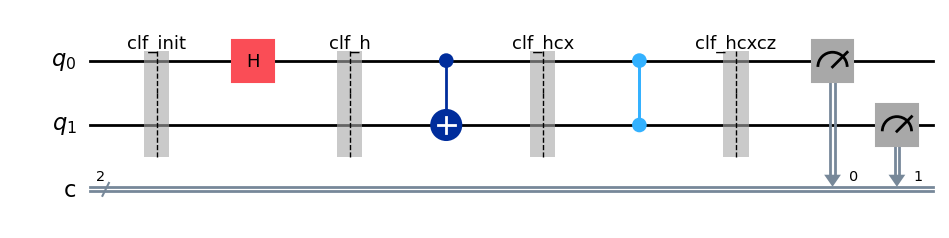

In [21]:
stab_simulator = AerSimulator(method='stabilizer')

n_qubits = 2
qc = QuantumCircuit(n_qubits, n_qubits)
qc.save_clifford(label='clf_init')

qc.h(0)
qc.save_clifford(label='clf_h')

qc.cx(0, 1)
qc.save_clifford(label='clf_hcx')

qc.cz(0, 1)
qc.save_clifford(label='clf_hcxcz')

qc.measure(range(n_qubits), range(n_qubits))
tcirc = transpile(qc, stab_simulator)
result = stab_simulator.run(tcirc).result()

qc.draw(output="mpl")
plt.show()

初期状態 $|00\rangle$ のスタビライザー演算子は $I_2Z_1、Z_2I_1$ であるため、バイナリー・テーブルは次のように表されます。

| |$x_1x_2$|$z_1z_2$|
|-|-|-|
|$Z_1I_2$|$00$|$10$|
|$I_1Z_2$|$00$|$01$|

In [22]:
result.data(0)['clf_init'].stab.astype(int)

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

シミュレーターでは、テーブルの最後にグローバル・フェーズを処理するために列が追加されています。

Hゲートが第1量子ビットに作用した後の量子状態は、列を$x_1$と$z_1$の間で入れ替えることで見ることができます。


In [23]:
result.data(0)['clf_h'].stab.astype(int)

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

このときのスタビライザーは $X_1I_2,I_1Z_2$ なので、量子状態は $|0\rangle \otimes \frac{|0\rangle+|1\rangle}{\sqrt{2}}$ です。(右端の量子ビットは 1 番目の量子ビットであることに注意してください。)

CNOTゲートを第1量子ビットを制御、第2量子ビットをターゲットとして作用します。 
バイナリー・テーブルは、$x_2^{new}=x_1\oplus x_2、z_1^{new}=z_1\oplus z_2$ によって更新されます。

In [24]:
result.data(0)['clf_hcx'].stab.astype(int)

array([[1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0]])

スタビライザー演算子は $X_1X_2$ と $Z_1 Z_2$ であるため、現在の量子状態は $\frac{|00\rangle+|11\rangle}{\sqrt{2}}$ です。

CZゲートを第1量子ビットを制御、第2量子ビットをターゲットとして作用します。 

バイナリー・テーブルは、$z_1^{new}=x_2\oplus z_1、z_2^{new}=x_1\oplus z_2$によって更新されます。


In [25]:
result.data(0)['clf_hcxcz'].stab.astype(int)

array([[1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0]])

スタビライザー演算子は $Y_1Y_2、Z_1Z_2$ であるため、このときの量子状態は $(|00\rangle-|11\rangle)/\sqrt{2}$ です。

In [26]:
result.data(0)['counts']

{'0x0': 493, '0x3': 531}

クリフォード・ゲートには、回転角度が $m\pi/2$ ($m$ は整数) の単一量子ビット ゲートも含まれます。

# statevector、MPS、スタビライザー・シミュレーターの実行時間の比較 
GHZ状態を生成する実行時間を比較します。


In [27]:
statevec_simulator = AerSimulator(method='statevector')
stab_simulator = AerSimulator(method='stabilizer')
mps_simulator = AerSimulator(method='matrix_product_state')

def simulation(n_qubits, simulator):
    circ = QuantumCircuit(n_qubits, n_qubits)
    circ.h(0)
    for i in range (0, n_qubits-1):
        circ.cx(i, i+1)
    circ.measure(range(n_qubits), range(n_qubits))
    tcirc = transpile(circ, simulator)
    result = simulator.run(tcirc).result()
    return result.time_taken

nqubits_state_vec_list = [i for i in range(10,25,2)]
nqubits_mps_list = [i for i in range(10,61,5)]
nqubits_stab_list = [i for i in range(10,101,5)]
statevec_exec_time = [simulation(n_qubits, statevec_simulator) for n_qubits in nqubits_state_vec_list ]
mps_exec_time = [simulation(n_qubits, mps_simulator) for n_qubits in nqubits_mps_list]
stab_exec_time = [simulation(n_qubits, stab_simulator) for n_qubits in nqubits_stab_list]

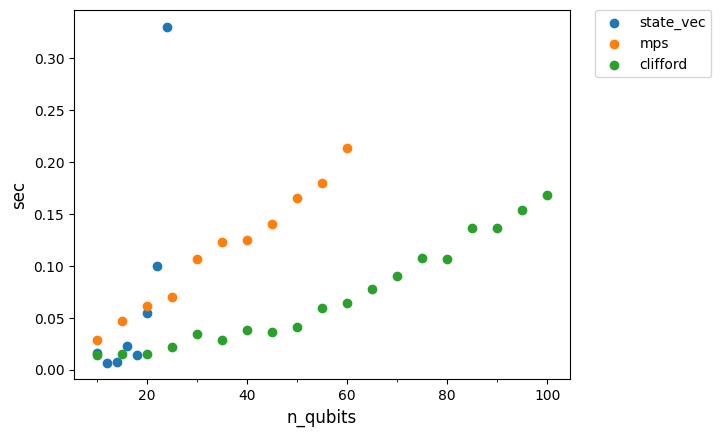

In [28]:
plt.scatter(nqubits_state_vec_list, statevec_exec_time, label="state_vec")
plt.scatter(nqubits_mps_list, mps_exec_time, label="mps")
plt.scatter(nqubits_stab_list, stab_exec_time, label="clifford")
plt.xlabel("n_qubits", fontsize=12)
plt.xticks(np.linspace(10,100,10),minor=True)
plt.ylabel("sec", fontsize=12)
#plt.ylim(0,0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

スタビライザー・シミュレーターは高速で、100量子ビットをシミュレートできます。 
MPS シミュレーターはスタビライザー・シミュレーターよりも遅いですが、60 量子ビットをシミュレートできます。 
Statevectorシミュレーターは、20量子ビット未満において、MPSシミュレーターよりも高速です(これはキャッシュサイズによって異なります)が、実行時間とメモリー要件は 20 量子ビットを超えると指数関数的に増加します。


次に、以下のイジング・ハミルトニアンのシミュレーション時間を比較します。 

$$H=h \sum_{i=1}^n X_i + j \sum_{i=1}^n \sum_{j=1}^i Z_iZ_j$$

トロッター分解を用いて、以下の回路を計算します。

$$e^{-iH \Delta t} \simeq (\Pi_{j=1}^n e^{-i h X_j \Delta t})(\Pi_{j=1}^n \Pi_{k=1}^{j-1} e^{-i J Z_j Z_k \Delta t})$$

初期状態は $|+\rangle^{\otimes n}$ として準備します。


In [29]:
J = np.random.rand()
h = np.random.rand()

delta = 1e-3
def simulating_ising_model(n_qubits, simulator):
    qc = QuantumCircuit(n_qubits, n_qubits)
    # to prepare |+...+>
    for i in range(n_qubits):
        qc.h(i)
    # time-evolution by Ising Hamiltonian
    for i in range(n_qubits):
        qc.rx(-2*(-h*delta), i)
    for i in range(n_qubits):
        for j in range(i):
            qc.rzz(-2*(-J*delta), i, j)
    qc.measure(range(n_qubits), range(n_qubits))
    tcirc = transpile(qc, simulator)
    result = simulator.run(tcirc).result()
    return result.time_taken

nqubits_state_vec_list = [i for i in range(10,25,2)]
nqubits_mps_list = [i for i in range(10,61,5)]
statevec_exec_time = [simulating_ising_model(n_qubits, statevec_simulator) for n_qubits in nqubits_state_vec_list ]
mps_exec_time = [simulating_ising_model(n_qubits, mps_simulator) for n_qubits in nqubits_mps_list]

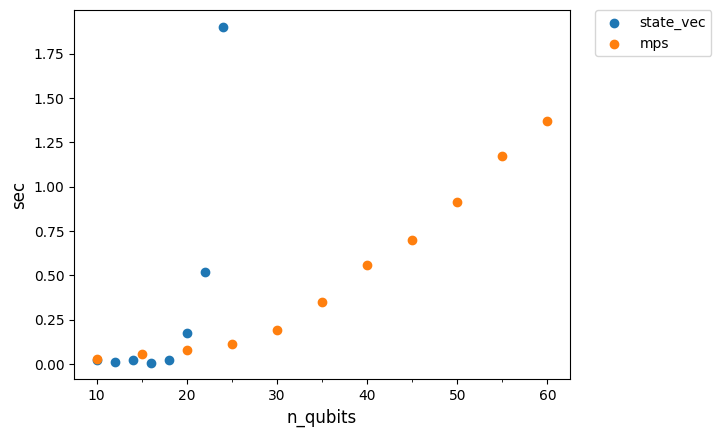

In [30]:
plt.scatter(nqubits_state_vec_list, statevec_exec_time, label="state_vec")
plt.scatter(nqubits_mps_list, mps_exec_time, label="mps")
plt.xlabel("n_qubits", fontsize=12)
plt.xticks(np.linspace(10,60,11),minor=True)
plt.ylabel("sec", fontsize=12)
#plt.ylim(0,1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

さきほどの結果と同様に、MPSシミュレーターを使用すると、Statevectorシミュレータよりも大きなシステムをシミュレートできます。